<center>

# **MICROPROYECTO 2  - CLUSTERING:** Censo USA Oeste.
---
Introducción a la Inteligencia Artificial, Código: 3010476

Inteligencia Artificial, Código: 3007855

---

**Profesor:**

Demetrio Arturo Ovalle Carranza

---

**Monitores:**

Daniel Metaute Medina

Felipe Muñoz Echeverri

---

**Estudiantes:**

Carlos Jose Quijano Valencia

Juan David Cortés Amador

Jose Fernando López Ramírez

---
</center>


# **Objetivo**: Analizar el Censo en USA de ciudades y estados más al oeste de EEUU (10 estados).

Importamos las librerias necesarias

In [41]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from tabulate import tabulate 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering


%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

Cargamos el dataset

In [42]:
data = pd.read_csv("census.csv")

Ordenamos aleatoriamente el dataset antes de cualquier preprocesamiento.

In [43]:
census_df = data.sample(frac=1).reset_index(drop=True)

Sacamos solo los lugares que pertencen mas al Oeste de USA.
Además, parece que en el dataset están unidos tanto condados y estados. 
Así que se filtrara por condado, ciudad y estado. 

In [44]:
west_states = [
    'Hawaii', 'Washington', 'Oregon', 'Idaho', 'California', 
    'Nevada', 'Utah', 'Arizona', 'Colorado', 'New Mexico'
]

#
west_census = census_df[census_df['STNAME'].isin(west_states)]
#Estados
state_west_census = west_census[west_census['SUMLEV'] == 40]
#Condados
county_west_census = west_census[west_census['SUMLEV'] == 50]


In [45]:
county_west_census.shape

(340, 100)

Haremos un analisis de correlación para eliminar variables redundantes.

93
['ESTIMATESBASE2010', 'POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014', 'POPESTIMATE2015', 'NPOPCHG_2011', 'NPOPCHG_2012', 'NPOPCHG_2013', 'NPOPCHG_2014', 'NPOPCHG_2015', 'BIRTHS2010', 'BIRTHS2011', 'BIRTHS2012', 'BIRTHS2013', 'BIRTHS2014', 'BIRTHS2015', 'DEATHS2010', 'DEATHS2011', 'DEATHS2012', 'DEATHS2013', 'DEATHS2014', 'DEATHS2015', 'NATURALINC2010', 'NATURALINC2011', 'NATURALINC2012', 'NATURALINC2013', 'NATURALINC2014', 'NATURALINC2015', 'INTERNATIONALMIG2010', 'INTERNATIONALMIG2011', 'INTERNATIONALMIG2012', 'INTERNATIONALMIG2013', 'INTERNATIONALMIG2014', 'INTERNATIONALMIG2015', 'DOMESTICMIG2011', 'DOMESTICMIG2013', 'DOMESTICMIG2014', 'DOMESTICMIG2015', 'NETMIG2010', 'NETMIG2011', 'NETMIG2012', 'NETMIG2013', 'NETMIG2014', 'NETMIG2015', 'RESIDUAL2011', 'RESIDUAL2014', 'GQESTIMATESBASE2010', 'GQESTIMATES2010', 'GQESTIMATES2011', 'GQESTIMATES2012', 'GQESTIMATES2013', 'GQESTIMATES2014', 'GQESTIMATES2015', 'RBIRTH2012', 'RBIRTH2013', 'RBI

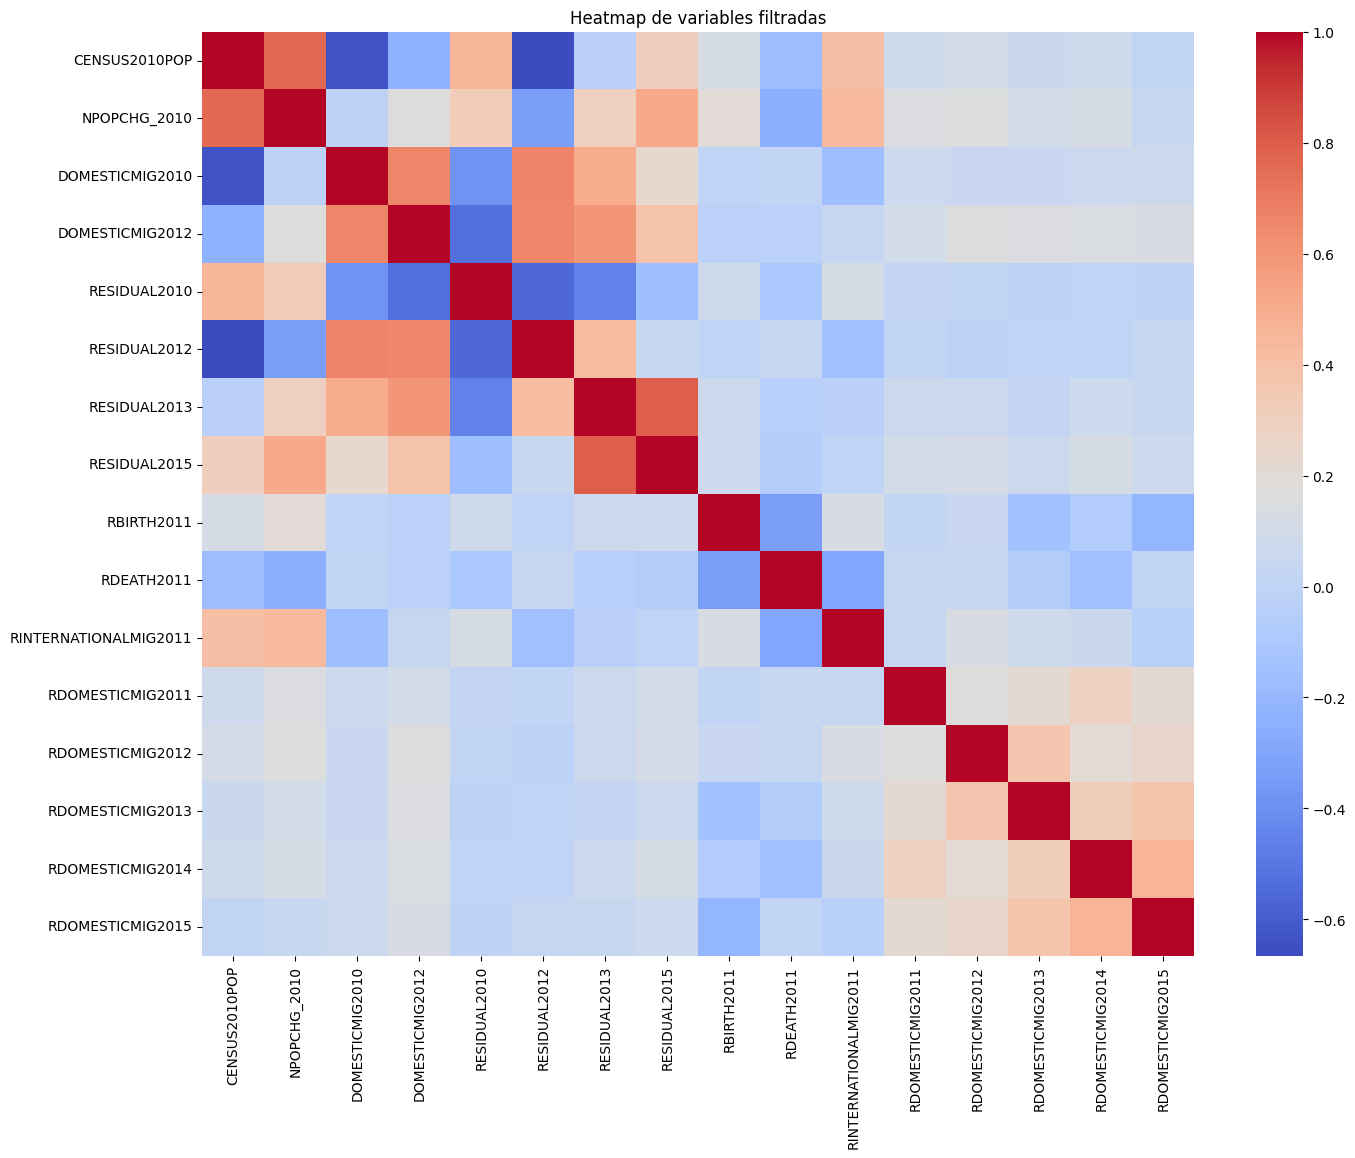

In [59]:
#eliminamos las columnas que no son de interés
county_west_census_filtered = county_west_census.drop(columns=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME'])
print(len(county_west_census_filtered.columns))
#analizamos la correlación entre todas las variables y eliminamos una de las que estén muy correlacionadas
correlation = county_west_census_filtered.corr()
threshold = 0.8
corr_matrix = correlation.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
filtered_data = county_west_census_filtered.drop(columns=to_drop)
print(to_drop)
print(len(filtered_data.columns))
plt.figure(figsize=(16, 12))
sb.heatmap(filtered_data.corr(), cmap='coolwarm', annot=False)
plt.title("Heatmap de variables filtradas")
plt.show()


In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd

# Estandariza los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(filtered_data)

# Aplica PCA a los datos estandarizados
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)
print(sum(pca.explained_variance_ratio_[:3]))

# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])

fig = px.scatter_3d(
    pca_df,
    x="PC1",  # Eje X: Componente Principal 1
    y="PC2",  # Eje Y: Componente Principal 2
    z="PC3",  # Eje Z: Componente Principal 3
    title="Gráfico Interactivo en 3D de Componentes Principales",
    labels={"PC1": "Componente Principal 1", "PC2": "Componente Principal 2", "PC3": "Componente Principal 3"},
    opacity=0.7
)

# Mostrar el gráfico interactivo
fig.show()


0.53112939896626


In [56]:
# Obtener las cargas de los componentes principales
loadings = pd.DataFrame(pca.components_, columns=filtered_data.columns, index=[f"PC{i+1}" for i in range(pca.n_components_)])
print(loadings)


     CENSUS2010POP  RESIDUAL2010  RBIRTH2011  RDEATH2011  \
PC1       0.226498      0.109524   -0.052243   -0.129418   
PC2       0.484012      0.381897    0.395453   -0.405355   
PC3       0.402989      0.546489   -0.497851    0.507874   

     RINTERNATIONALMIG2011  RDOMESTICMIG2011  RDOMESTICMIG2012  \
PC1               0.199640          0.333754          0.384763   
PC2               0.438062         -0.078803         -0.033846   
PC3              -0.041535         -0.019789         -0.048709   

     RDOMESTICMIG2013  RDOMESTICMIG2014  RDOMESTICMIG2015  
PC1          0.455678          0.464239          0.441332  
PC2         -0.151465         -0.105945         -0.256459  
PC3         -0.046965         -0.158050          0.038522  


In [49]:
pca_df

,PC1,PC2,PC3
0,-0.926625,0.832628,-0.772091
1,-2.354611,-0.853822,1.136872
2,-3.689396,0.953326,0.292096
3,0.651083,-2.137570,1.160668
4,1.350012,-0.390461,-0.392286
...,...,...,...
335,-2.952718,1.369038,-0.889656
336,3.392863,-0.622705,-1.672558
337,0.539397,-1.162457,0.553898
338,0.805621,-0.073673,-1.052576


Curva de codo

In [50]:
def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)

  # Grafico de los resultados obtenidos para cada valor del rango
  print("Valores: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

Valores:  [1805.8399564852832, 1338.366128464202, 1010.3653762628737, 726.1571667600339, 644.7834339728037, 500.8112686767808, 435.65755654282293, 419.9941288778273, 344.93266039076155, 306.042472785713, 272.42079325719084, 256.49706448961973, 235.65574451915205, 237.02678060597796, 209.81212772126904]


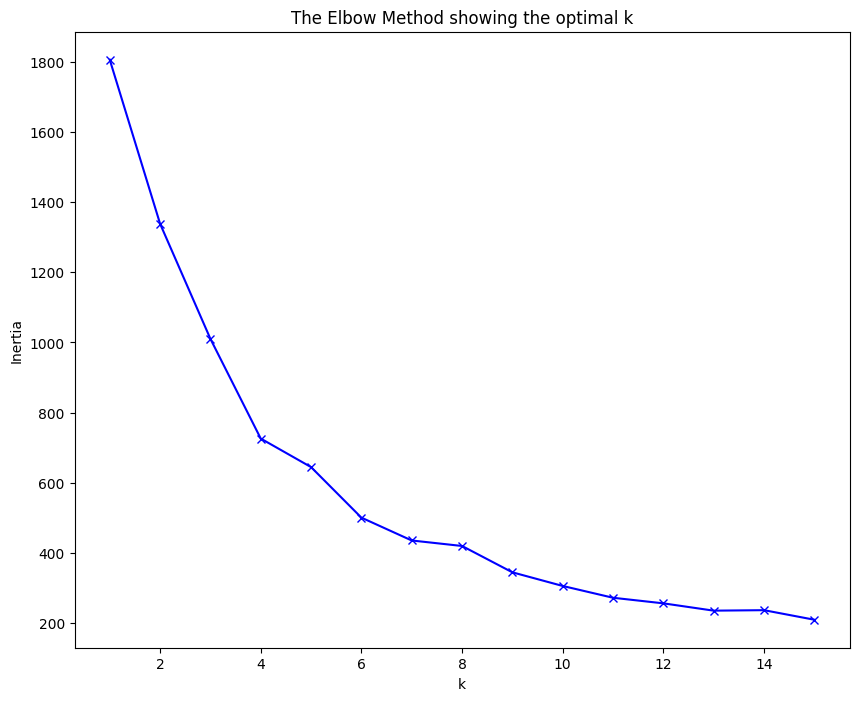

In [51]:
elbow_curve(pca_df, maxClusters= 15)

In [52]:
# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def optimalK(data, nrefs=3, maxClusters=15):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):

            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)

            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap

        resultsdf.loc[gap_index] = [k, gap]

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve
    # su respectivo número de clusters
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return(i+1, resultsdf)
    return (len(gaps), resultsdf)
    #return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [53]:
k, gapdf = optimalK(pca_data, nrefs=5, maxClusters=10)
print('La cantidad óptima de clusters es: ', k)

La cantidad óptima de clusters es:  1


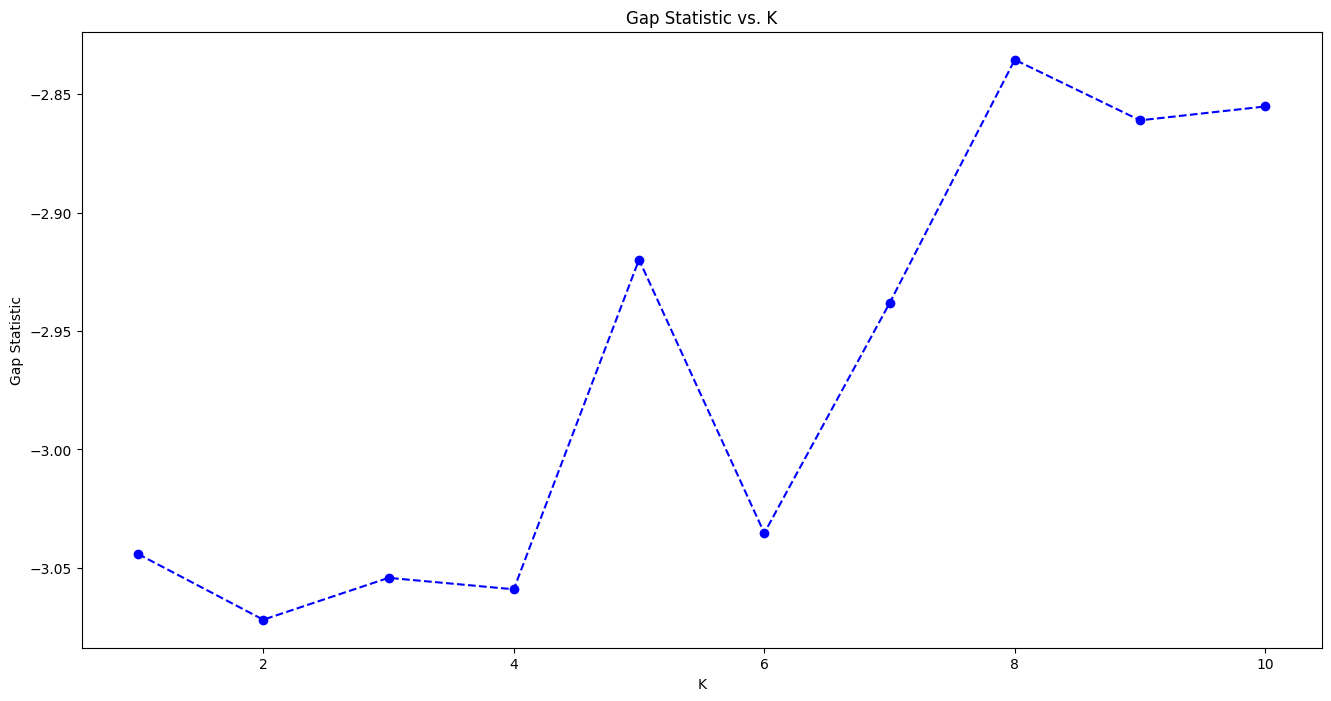

In [54]:
plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

Coeficiente de silueta

For n_clusters = 2 The average silhouette_score is : 0.2860388996961048
For n_clusters = 3 The average silhouette_score is : 0.32248451599828093
For n_clusters = 4 The average silhouette_score is : 0.3176773655815241
For n_clusters = 5 The average silhouette_score is : 0.3065591561210339
For n_clusters = 6 The average silhouette_score is : 0.3196947927751354
For n_clusters = 7 The average silhouette_score is : 0.2905610185334739
For n_clusters = 8 The average silhouette_score is : 0.27515424815249095


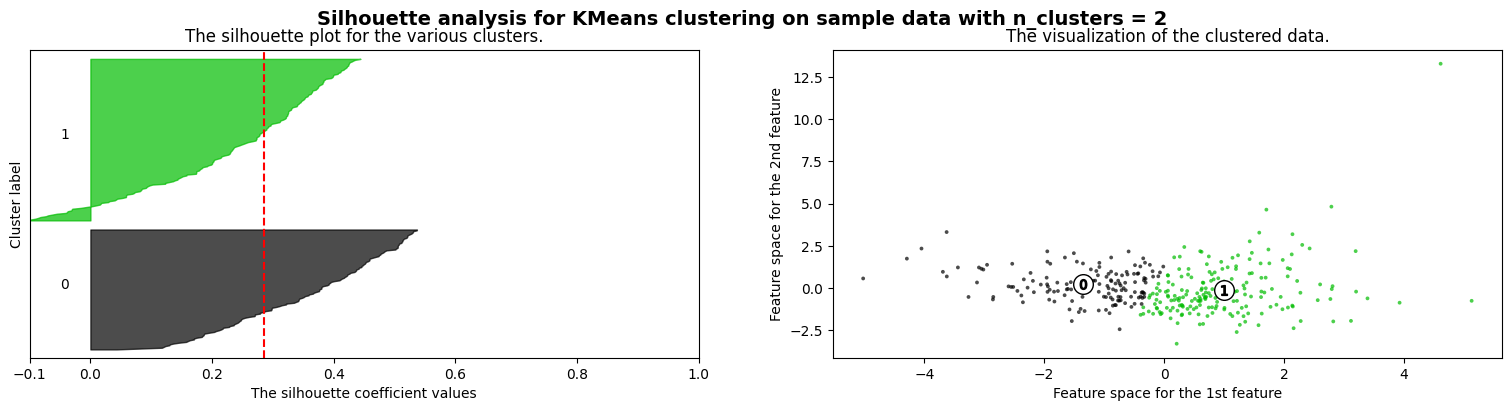

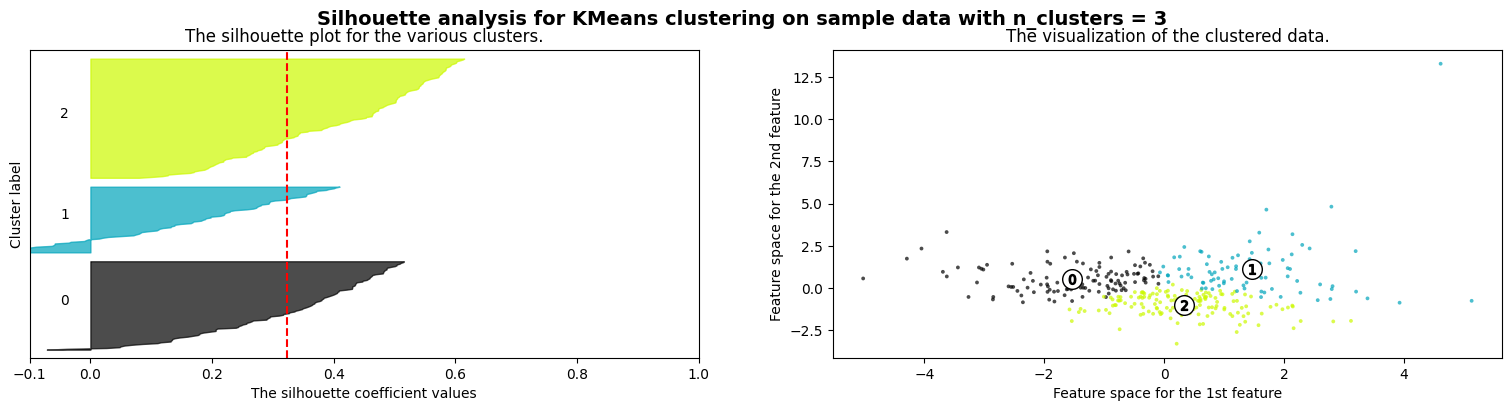

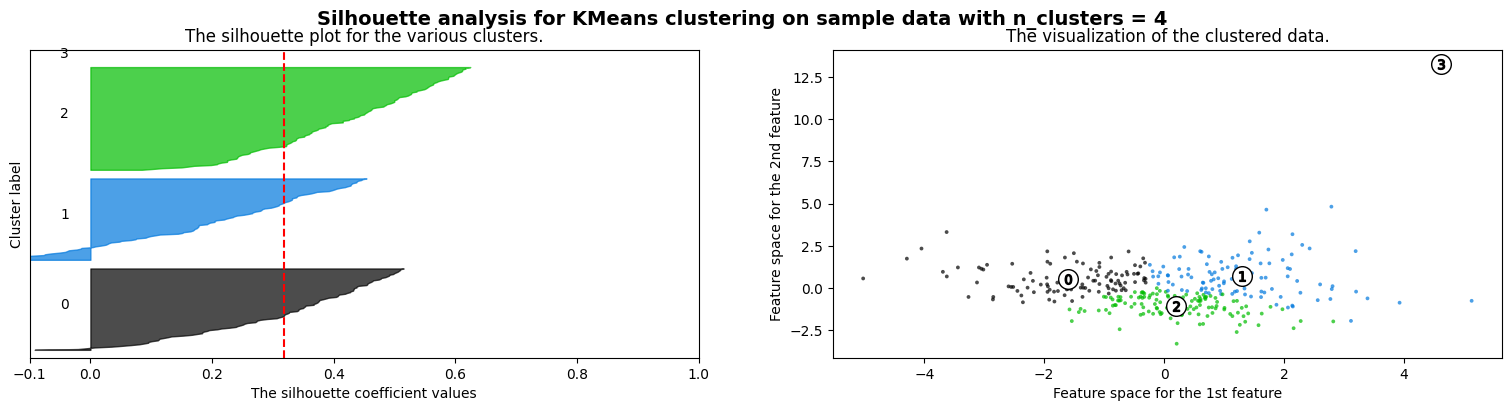

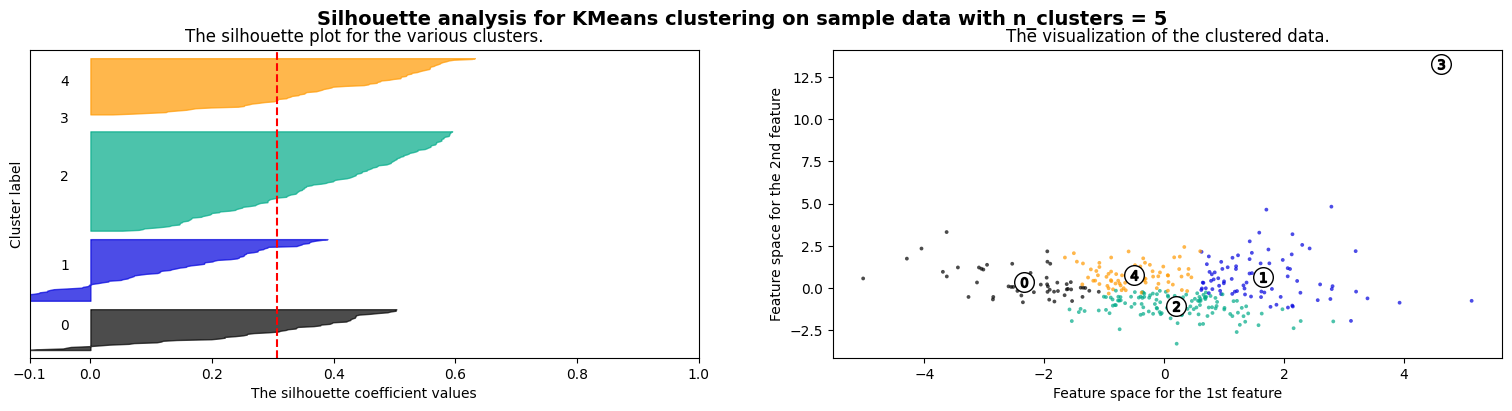

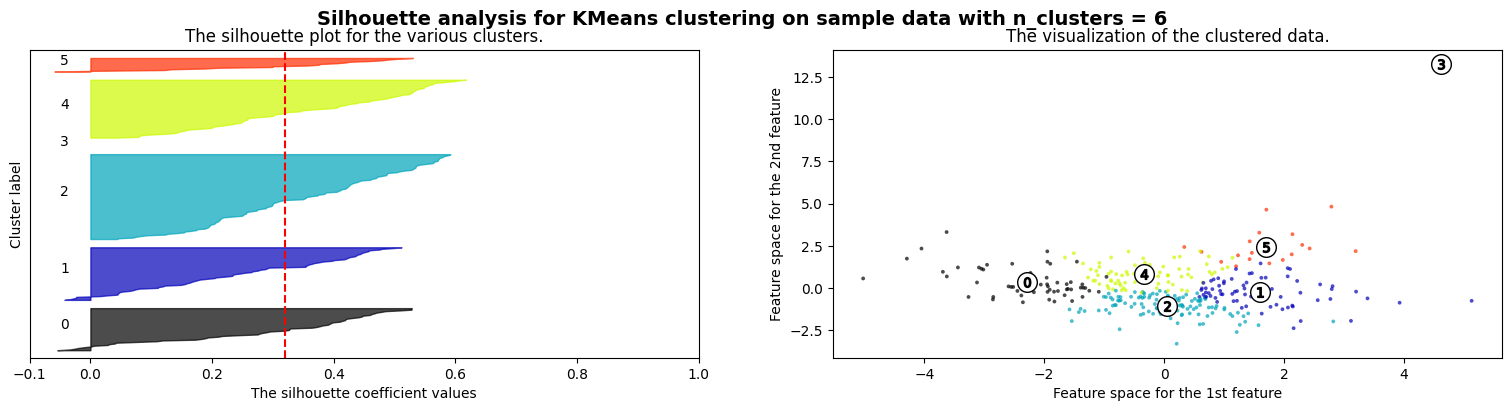

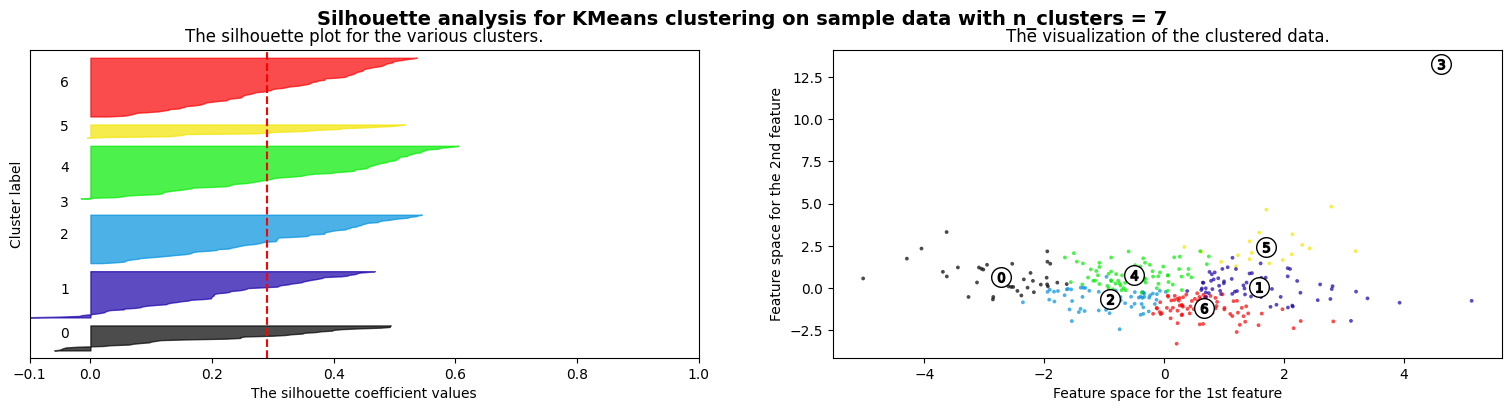

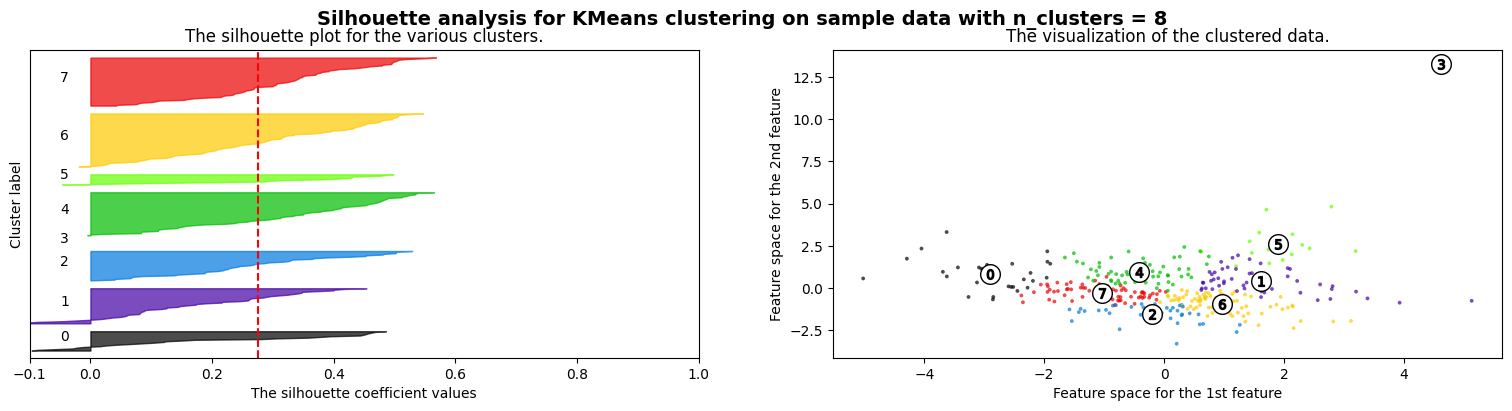

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

colors_k_means = ['cyan','purple','orange']
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
X = pca_df.values

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()